
# Practica 4 - Base Unificada (Listings)

Objetivo: construir una base unificada con **listings.csv** y aplicar tecnicas vistas en los notebooks `source/##_*.ipynb`.

- Target principal: **price** (regresion)
- Dataset: **local** `listings.csv`
- Incluye: EDA profundo + diccionario de datos, limpieza, ingenieria de variables, seleccion de variables,
  modelos lineales/regularizados, KNN, SVM/SVR, Kernel Ridge, SGD, arboles, ensambles, redes neuronales,
  y una seccion auxiliar de clasificacion por segmentos de precio para aplicar LDA/Naive Bayes.


In [13]:

# === 1) Imports y configuracion ===
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import re

import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_regression

# Modelos regresion
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, BayesianRidge, SGDRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import (
    RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, ExtraTreesRegressor,
    VotingRegressor
)
from sklearn.neural_network import MLPRegressor

# Modelos clasificacion (auxiliar)
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# Metricas
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, root_mean_squared_error
from sklearn.metrics import accuracy_score, f1_score


In [14]:
DATA_DIR = Path("data")

if not Path(DATA_DIR).exists():
    raise FileNotFoundError(f"No existe {DATA_DIR} en el directorio actual")

raw = pd.read_csv(DATA_DIR / "listings.csv.gz", compression="gzip", low_memory=False)
print("Shape:", raw.shape)
raw.head(3)


Shape: (27051, 79)


,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,35797,https://www.airbnb.com/rooms/35797,20250927041820,2025-09-27,city scrape,Villa Dante,"Dentro de Villa un estudio de arte con futon, ...","Santa Fe Shopping Mall, Interlomas Park and th...",https://a0.muscache.com/pictures/f395ab78-1185...,153786,...,NaN,NaN,NaN,NaN,f,1,1,0,0,NaN
1,44616,https://www.airbnb.com/rooms/44616,20250927041820,2025-09-28,city scrape,Condesa Haus,A new concept of hosting in mexico through a b...,NaN,https://a0.muscache.com/pictures/251410/ec75fe...,196253,...,4.78,4.98,4.47,NaN,f,9,4,2,0,0.38
2,56074,https://www.airbnb.com/rooms/56074,20250927041820,2025-09-28,city scrape,Great space in historical San Rafael,This great apartment is located in one of the ...,Very traditional neighborhood with all service...,https://a0.muscache.com/pictures/3005118/60dac...,265650,...,4.94,4.76,4.79,NaN,f,1,1,0,0,0.48


## 3) EDA profundo y diccionario de datos

In [15]:

# Vista rapida
raw.info()


<class 'pandas.DataFrame'>
RangeIndex: 27051 entries, 0 to 27050
Data columns (total 79 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            27051 non-null  int64  
 1   listing_url                                   27051 non-null  str    
 2   scrape_id                                     27051 non-null  int64  
 3   last_scraped                                  27051 non-null  str    
 4   source                                        27051 non-null  str    
 5   name                                          27051 non-null  str    
 6   description                                   26309 non-null  str    
 7   neighborhood_overview                         13736 non-null  str    
 8   picture_url                                   27051 non-null  str    
 9   host_id                                       27051 non-null  int64  
 1

In [16]:

# Resumen de nulos
missing = (raw.isna().mean() * 100).sort_values(ascending=False)
missing.head(20)


neighbourhood_group_cleansed    100.000000
calendar_updated                100.000000
license                         100.000000
neighborhood_overview            49.221840
neighbourhood                    49.221840
host_neighbourhood               45.336586
host_about                       40.031792
host_location                    21.540793
host_response_rate               14.620532
host_response_time               14.620532
beds                             12.960704
bathrooms                        12.923737
estimated_revenue_l365d          12.879376
price                            12.879376
review_scores_location           12.576245
review_scores_value              12.576245
review_scores_accuracy           12.576245
review_scores_cleanliness        12.576245
review_scores_checkin            12.576245
review_scores_communication      12.576245
dtype: float64

In [17]:

# Diccionario de datos

def build_data_dictionary(df):
    rows = []
    n = len(df)
    for col in df.columns:
        s = df[col]
        dtype = str(s.dtype)
        n_missing = s.isna().sum()
        pct_missing = (n_missing / n) * 100
        n_unique = s.nunique(dropna=True)
        pct_unique = (n_unique / n) * 100
        sample = s.dropna().astype(str).head(3).tolist()
        mean_len = None
        if s.dtype == 'object':
            mean_len = s.dropna().astype(str).str.len().mean()
        rows.append({
            'column': col,
            'dtype': dtype,
            'n_missing': n_missing,
            'pct_missing': round(pct_missing, 2),
            'n_unique': n_unique,
            'pct_unique': round(pct_unique, 2),
            'mean_len': round(mean_len, 2) if mean_len else None,
            'sample': sample
        })
    return pd.DataFrame(rows)


data_dict = build_data_dictionary(raw)
data_dict.head(10)


,column,dtype,n_missing,pct_missing,n_unique,pct_unique,mean_len,sample
0,id,int64,0,0.00,27051,100.00,None,"[35797, 44616, 56074]"
1,listing_url,str,0,0.00,27051,100.00,None,"[https://www.airbnb.com/rooms/35797, https://w..."
2,scrape_id,int64,0,0.00,1,0.00,None,"[20250927041820, 20250927041820, 20250927041820]"
3,last_scraped,str,0,0.00,2,0.01,None,"[2025-09-27, 2025-09-28, 2025-09-28]"
4,source,str,0,0.00,2,0.01,None,"[city scrape, city scrape, city scrape]"
5,name,str,0,0.00,25638,94.78,None,"[Villa Dante, Condesa Haus, Great space in his..."
6,description,str,742,2.74,22124,81.79,None,"[Dentro de Villa un estudio de arte con futon,..."
7,neighborhood_overview,str,13315,49.22,10108,37.37,None,"[Santa Fe Shopping Mall, Interlomas Park and t..."
8,picture_url,str,0,0.00,26219,96.92,None,[https://a0.muscache.com/pictures/f395ab78-118...
9,host_id,int64,0,0.00,12046,44.53,None,"[153786, 196253, 265650]"


In [18]:

# Heuristicas para candidatos a eliminar

def detect_drop_candidates(df, missing_threshold=60, high_card_threshold=200, long_text_len=80):
    rows = []
    n = len(df)
    for col in df.columns:
        s = df[col]
        name = col.lower()
        n_unique = s.nunique(dropna=True)
        pct_unique = (n_unique / n) * 100 if n else 0
        pct_missing = s.isna().mean() * 100
        reasons = []

        # Constantes
        if n_unique <= 1:
            reasons.append('constant')

        # Muchos nulos
        if pct_missing > missing_threshold:
            reasons.append(f'missing>{missing_threshold}%')

        # IDs / URL / metadata
        if 'url' in name or s.astype(str).str.contains('http', case=False, na=False).mean() > 0.2:
            reasons.append('url_like')
        if 'scrape' in name:
            reasons.append('scrape_meta')
        if name == 'id' or name.endswith('id') or 'id_' in name:
            if pct_unique > 90:
                reasons.append('id_like')

        # Texto largo / alta cardinalidad
        if s.dtype == 'object':
            mean_len = s.dropna().astype(str).str.len().mean()
            if mean_len and mean_len > long_text_len:
                reasons.append('long_text')
            if n_unique > high_card_threshold:
                reasons.append('high_cardinality')

        if reasons:
            rows.append({
                'column': col,
                'reasons': ', '.join(reasons),
                'pct_missing': round(pct_missing, 2),
                'pct_unique': round(pct_unique, 2),
                'n_unique': n_unique
            })

    report = pd.DataFrame(rows).sort_values(by=['pct_missing', 'n_unique'], ascending=False)
    candidates = report['column'].tolist()
    return report, candidates


drop_report, drop_candidates = detect_drop_candidates(raw)

# Columnas que NO queremos eliminar aunque salgan como candidatas
protect_cols = ['price', 'amenities', 'neighbourhood_cleansed', 'property_type', 'room_type']
drop_candidates = [c for c in drop_candidates if c not in protect_cols]

drop_report.head(20)


,column,reasons,pct_missing,pct_unique,n_unique
8,neighbourhood_group_cleansed,"constant, missing>60%",100.00,0.00,0
9,calendar_updated,"constant, missing>60%",100.00,0.00,0
12,license,"constant, missing>60%",100.00,0.00,0
10,has_availability,constant,3.76,0.00,1
6,host_thumbnail_url,url_like,0.02,42.98,11626
7,host_picture_url,url_like,0.02,42.98,11626
0,id,id_like,0.00,100.00,27051
1,listing_url,url_like,0.00,100.00,27051
4,picture_url,url_like,0.00,96.92,26219
5,host_url,url_like,0.00,44.53,12046


In [19]:

# Candidatos a eliminar (resumen)
print("Total candidatos:", len(drop_candidates))
print(drop_candidates[:20])


Total candidatos: 13
['neighbourhood_group_cleansed', 'calendar_updated', 'license', 'has_availability', 'host_thumbnail_url', 'host_picture_url', 'id', 'listing_url', 'picture_url', 'host_url', 'last_scraped', 'calendar_last_scraped', 'scrape_id']


In [20]:

# Columnas relacionadas con price (posible leakage si se usan como features)
price_cols = [c for c in raw.columns if 'price' in c.lower()]
price_cols


['price']

In [21]:
# Correlaciones con el target (Spearman) - numericas
eda_df = raw.copy()

# price_clean temporal para EDA
if 'price' in eda_df.columns:
    eda_df['price_clean'] = (
        eda_df['price'].astype(str)
        .str.replace(r"[,\$]", "", regex=True)
        .str.strip()
    )
    eda_df['price_clean'] = pd.to_numeric(eda_df['price_clean'], errors='coerce')

num_cols = eda_df.select_dtypes(include=[np.number]).columns.tolist()
num_cols = [c for c in num_cols if c != 'price_clean']

corr = eda_df[num_cols].corrwith(eda_df['price_clean'], method='spearman').sort_values(ascending=False)
print("Top correlaciones positivas:")
print(corr.head(10))
print("")
print("Top correlaciones negativas:")
print(corr.tail(10))


Top correlaciones positivas:
accommodates                                   0.561146
bedrooms                                       0.483512
beds                                           0.432543
calculated_host_listings_count_entire_homes    0.413786
bathrooms                                      0.373945
estimated_revenue_l365d                        0.318499
review_scores_location                         0.206471
review_scores_cleanliness                      0.185407
host_total_listings_count                      0.155475
review_scores_accuracy                         0.154834
dtype: float64

Top correlaciones negativas:
availability_365                               -0.061372
availability_90                                -0.065948
availability_eoy                               -0.077125
calculated_host_listings_count_shared_rooms    -0.179259
longitude                                      -0.241144
calculated_host_listings_count_private_rooms   -0.397759
scrape_id               

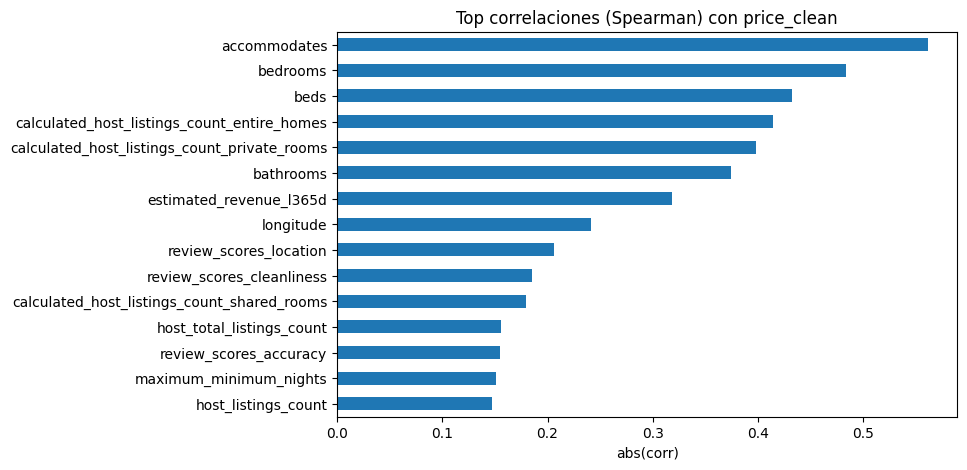

In [22]:

# Visualizacion de top correlaciones (absolutas)
if len(corr) > 0:
    top_corr = corr.abs().sort_values(ascending=False).head(15)
    plt.figure(figsize=(8, 5))
    top_corr.sort_values().plot(kind='barh')
    plt.title('Top correlaciones (Spearman) con price_clean')
    plt.xlabel('abs(corr)')
    plt.show()


## 4) Limpieza y feature engineering

In [23]:

# Copia de trabajo
_df = raw.copy()

# Limpieza de price -> numerico
if 'price' in _df.columns:
    _df['price_clean'] = (
        _df['price'].astype(str)
        .str.replace(r"[,\$]", "", regex=True)
        .str.strip()
    )
    _df['price_clean'] = pd.to_numeric(_df['price_clean'], errors='coerce')
else:
    raise ValueError("La columna 'price' no existe en listings.csv")

# Bathrooms desde bathrooms_text (si existe)
if 'bathrooms_text' in _df.columns:
    _df['bathrooms_count'] = (
        _df['bathrooms_text'].astype(str)
        .str.extract(r"(\d+\.?\d*)")[0]
        .astype(float)
    )

# Amenities -> lista y conteo
if 'amenities' in _df.columns:
    def _clean_amenities(text):
        if pd.isna(text):
            return []
        text = text.replace('[', '').replace(']', '').replace('"', '')
        return [x.strip() for x in text.split(',') if x.strip()]

    _df['amenities_list'] = _df['amenities'].apply(_clean_amenities)
    _df['amenities_count'] = _df['amenities_list'].apply(len)

    # Algunas amenities binarias
    for amenity in [
        'Wifi', 'Air conditioning', 'Kitchen', 'Pool', 'Parking', 'Washer', 'Dryer'
    ]:
        col = f"has_{amenity.lower().replace(' ', '_')}"
        _df[col] = _df['amenities_list'].apply(
            lambda x: 1 if any(amenity.lower() in item.lower() for item in x) else 0
        )

# Variables binarias tipicas
for col in ['host_is_superhost', 'instant_bookable']:
    if col in _df.columns:
        _df[col] = _df[col].astype(str).str.lower().map({'t': 1, 'f': 0})

# Features de capacidad
for c in ['accommodates', 'bedrooms', 'beds']:
    if c not in _df.columns:
        _df[c] = np.nan

_df['total_capacity'] = _df['accommodates'].fillna(0) + _df['bedrooms'].fillna(0) + _df['beds'].fillna(0)
_df['bed_per_person'] = _df['beds'] / (_df['accommodates'].replace(0, np.nan))
_df['bedroom_per_person'] = _df['bedrooms'] / (_df['accommodates'].replace(0, np.nan))

# Reviews y calidad
for c in ['review_scores_rating', 'number_of_reviews', 'reviews_per_month']:
    if c not in _df.columns:
        _df[c] = np.nan

_df['reviews_per_month'] = pd.to_numeric(_df['reviews_per_month'], errors='coerce')

# Ubicacion: distancia al centro (CDMX aproximado)
if 'latitude' in _df.columns and 'longitude' in _df.columns:
    center_lat, center_lon = 19.4326, -99.1332
    _df['distance_from_center'] = np.sqrt(
        (_df['latitude'] - center_lat)**2 + (_df['longitude'] - center_lon)**2
    )
    _df['is_central_location'] = (_df['distance_from_center'] < 0.05).astype(int)

# Booking / disponibilidad
for c in ['minimum_nights', 'maximum_nights', 'availability_365']:
    if c not in _df.columns:
        _df[c] = np.nan

_df['booking_flexibility'] = _df['maximum_nights'] - _df['minimum_nights']
_df['availability_rate'] = _df['availability_365'] / 365
_df['scarcity_score'] = 1 - _df['availability_rate']

# Log transforms
for c in ['price_clean', 'number_of_reviews', 'reviews_per_month']:
    if c in _df.columns:
        _df[f'log_{c}'] = np.log1p(_df[c])



# Amenidades (todas) -> columnas binarias
if 'amenities_list' in _df.columns:
    # Lista completa de amenidades
    flat = [a for row in _df['amenities_list'] for a in row]
    amenity_counts = pd.Series(flat).value_counts()
    all_amenities = amenity_counts.index.tolist()

    def _sanitize_amenity(name: str) -> str:
        name = name.strip().lower()
        name = re.sub(r'[^0-9a-zA-Z]+', '_', name)
        return 'amenity_' + name.strip('_')

    # Evitar colisiones de nombres
    col_map = {}
    used = set()
    for a in all_amenities:
        base = _sanitize_amenity(a)
        col = base
        k = 2
        while col in used:
            col = f"{base}_{k}"
            k += 1
        col_map[a] = col
        used.add(col)

    # Crear matriz binaria (sparse) para todas las amenidades
    from sklearn.preprocessing import MultiLabelBinarizer
    mlb = MultiLabelBinarizer(classes=all_amenities, sparse_output=True)
    amenity_mat = mlb.fit_transform(_df['amenities_list'])

    amenity_cols = [col_map[a] for a in mlb.classes_]
    amenity_df = pd.DataFrame.sparse.from_spmatrix(amenity_mat, index=_df.index, columns=amenity_cols)
    amenity_df = amenity_df.astype('int8')

    _df = pd.concat([_df, amenity_df], axis=1)

    print('Total amenidades creadas:', len(amenity_cols))

print("Shape despues de FE:", _df.shape)
_df[['price_clean']].describe()


Total amenidades creadas: 5057
Shape despues de FE: (27051, 5158)


,price_clean
count,23567.000000
mean,1792.540841
std,13230.940558
min,61.000000
25%,643.000000
50%,1039.000000
75%,1611.000000
max,900000.000000


### Correlacion de amenidades con price_clean


Amenities detectadas: 5065
Amenities válidas (no constantes): 5064


,feature,rho,p_value,prevalence,q_value,neglog10p
18,amenity_hair_dryer,0.322325,0.000000e+00,0.606373,0.000000e+00,300.000000
6,has_dryer,0.322125,0.000000e+00,0.678607,0.000000e+00,300.000000
40,amenity_elevator,0.319089,0.000000e+00,0.342575,0.000000e+00,300.000000
39,amenity_wine_glasses,0.299780,0.000000e+00,0.346863,0.000000e+00,300.000000
73,amenity_safe,0.279067,0.000000e+00,0.134487,0.000000e+00,300.000000
74,amenity_free_dryer_u2013_in_unit,0.251306,0.000000e+00,0.130309,0.000000e+00,300.000000
64,amenity_private_patio_or_balcony,0.244711,0.000000e+00,0.160696,0.000000e+00,300.000000
52,amenity_toaster,0.237776,3.419395e-300,0.251895,1.923980e-297,299.466051
38,amenity_coffee,0.237251,7.684630e-299,0.372519,3.891497e-296,298.114377
42,amenity_shower_gel,0.234059,1.102336e-290,0.324646,5.074753e-288,289.957686


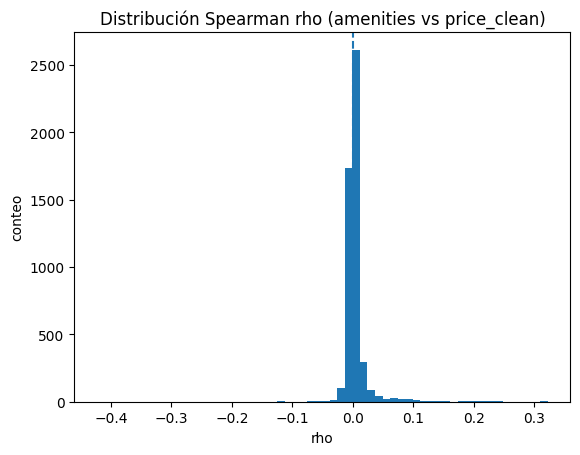

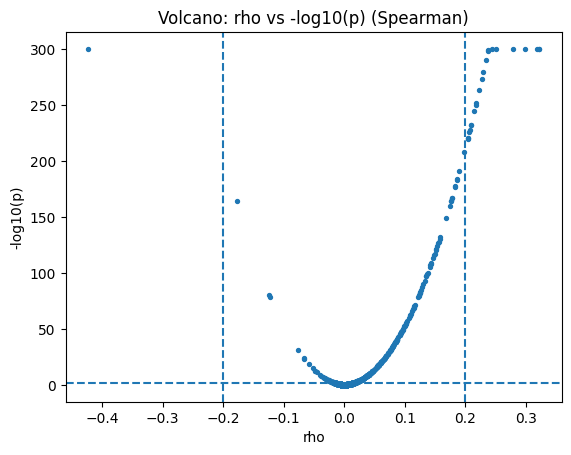

Amenities seleccionadas (filtro): 24


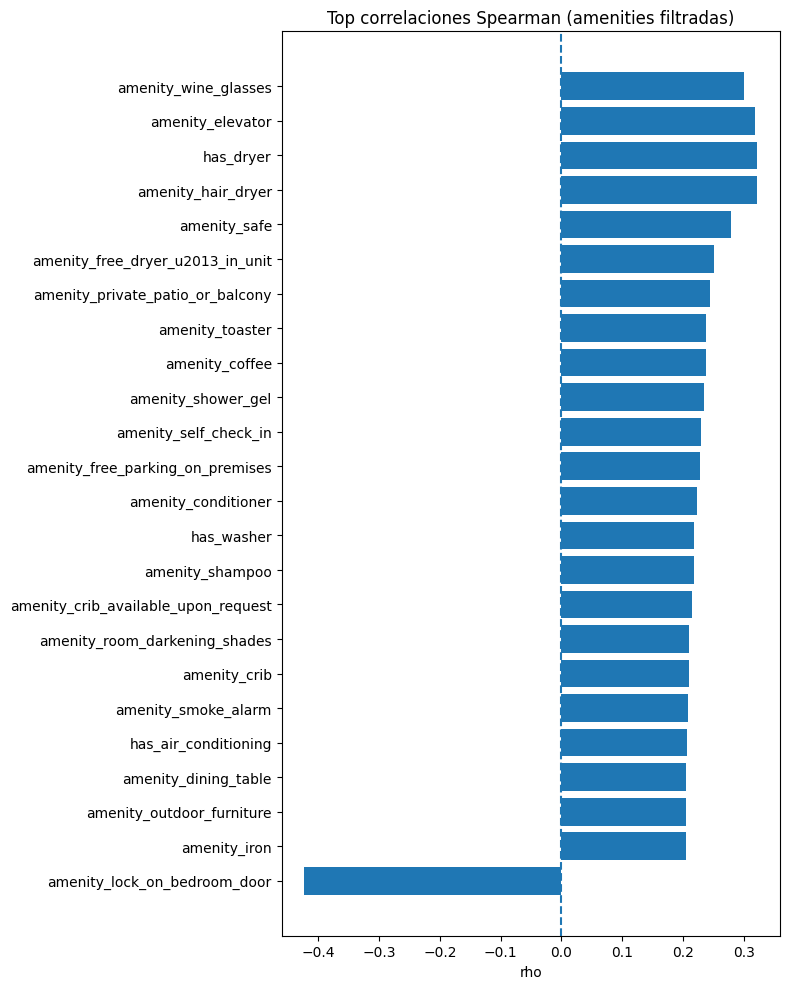

In [24]:
from scipy.stats import spearmanr

# 1) Selecciona columnas de amenities (amenity_ y has_)
amenity_cols = [c for c in _df.columns if c.startswith("amenity_") or c.startswith("has_")]
print("Amenities detectadas:", len(amenity_cols))

if not amenity_cols:
    print("No se detectaron columnas amenity_/has_.")
else:
    # 2) Target numérico
    price = pd.to_numeric(_df["price_clean"], errors="coerce")

    # 3) Convierte amenities a 0/1 numérico (por si traen 't'/'f' o 'True'/'False')
    def to_01(s: pd.Series) -> pd.Series:
        if pd.api.types.is_numeric_dtype(s):
            return pd.to_numeric(s, errors="coerce")

        x = s.astype(str).str.strip().str.lower()
        mapping = {
            "t": 1, "true": 1, "yes": 1, "y": 1, "1": 1,
            "f": 0, "false": 0, "no": 0, "n": 0, "0": 0,
            "nan": np.nan, "none": np.nan, "": np.nan
        }
        return x.map(mapping).astype(float)

    X_amen = _df[amenity_cols].apply(to_01)

    # 4) Quita constantes (no sirven para correlación)
    valid_cols = [c for c in X_amen.columns if X_amen[c].nunique(dropna=True) > 1]
    X_amen = X_amen[valid_cols]
    print("Amenities válidas (no constantes):", X_amen.shape[1])

    # 5) Spearman rho + p-value por columna
    results = []
    for c in X_amen.columns:
        rho, p = spearmanr(X_amen[c], price, nan_policy="omit")
        results.append((c, rho, p, X_amen[c].mean()))  # mean ~ prevalencia (si es 0/1)

    corr_df = pd.DataFrame(results, columns=["feature", "rho", "p_value", "prevalence"]).dropna()

    # 6) 
    p = corr_df["p_value"].values
    m = len(p)
    order = np.argsort(p)
    rank = np.empty(m, dtype=int)
    rank[order] = np.arange(1, m + 1)

    q = p * m / rank
    q_sorted = np.minimum.accumulate(q[order][::-1])[::-1]
    q_final = np.empty_like(q_sorted)
    q_final[order] = q_sorted

    corr_df["q_value"] = q_final
    corr_df["neglog10p"] = -np.log10(corr_df["p_value"].clip(lower=1e-300))

    corr_df = corr_df.sort_values("rho", ascending=False)
    display(corr_df.head(10))

    # 7) Gráfico A: Distribución de correlaciones
    plt.figure()
    plt.hist(corr_df["rho"], bins=60)
    plt.axvline(0, linestyle="--")
    plt.title("Distribución Spearman rho (amenities vs price_clean)")
    plt.xlabel("rho")
    plt.ylabel("conteo")
    plt.show()

    # 8) Gráfico B: Volcano (rho vs significancia)
    plt.figure()
    plt.scatter(corr_df["rho"], corr_df["neglog10p"], s=8)
    plt.axvline(+0.20, linestyle="--")
    plt.axvline(-0.20, linestyle="--")
    plt.axhline(-np.log10(0.05), linestyle="--")
    plt.title("Volcano: rho vs -log10(p) (Spearman)")
    plt.xlabel("rho")
    plt.ylabel("-log10(p)")
    plt.show()

    # 9) Filtra “reportables” y grafica Top-K
    rho_thr = 0.20
    q_thr = 0.05
    min_prev = 0.01  # 1% (ajústalo si te deja muy pocas o demasiadas)

    sel = corr_df[
        (corr_df["q_value"] < q_thr) &
        (corr_df["rho"].abs() >= rho_thr) &
        (corr_df["prevalence"] >= min_prev) &
        (corr_df["prevalence"] <= 1 - min_prev)
    ].copy()

    print("Amenities seleccionadas (filtro):", sel.shape[0])

    top_pos = sel.sort_values("rho", ascending=False).head(20)
    top_neg = sel.sort_values("rho", ascending=True).head(20)
    plot_df = pd.concat([top_neg, top_pos], axis=0)

    if plot_df.shape[0] > 0:
        plt.figure(figsize=(8, 10))
        plt.barh(plot_df["feature"], plot_df["rho"])
        plt.axvline(0, linestyle="--")
        plt.title("Top correlaciones Spearman (amenities filtradas)")
        plt.xlabel("rho")
        plt.ylabel("")
        plt.tight_layout()
        plt.show()
    else:
        print("Con esos umbrales no quedó ninguna. Baja rho_thr o min_prev.")


In [25]:
# --- Feature pruning (sin usar price): prevalencia extrema ---
amenity_cols = [c for c in _df.columns if c.startswith("amenity_") or c.startswith("has_")]

# Usa el mismo to_01 que ya definiste en esa celda
X_amen = _df[amenity_cols].apply(to_01)

# Quita constantes
X_amen = X_amen.loc[:, X_amen.nunique(dropna=True) > 1]

prev = X_amen.mean(skipna=True)

min_prev_keep = 0.01  # 1%
max_prev_keep = 0.99  # 99%

keep_amen = prev[(prev >= min_prev_keep) & (prev <= max_prev_keep)].index.tolist()
drop_amen = [c for c in amenity_cols if c not in keep_amen]

print("Amenities antes:", len(amenity_cols))
print("Amenities drop (prevalencia extrema):", len(drop_amen))
print("Amenities keep:", len(keep_amen))

_df = _df.drop(columns=drop_amen)

Amenities antes: 5065
Amenities drop (prevalencia extrema): 4856
Amenities keep: 209


## 5) Manejo de nulos y outliers

In [26]:

# Eliminar filas sin target
_df = _df.dropna(subset=['price_clean']).copy()

# Clip outliers en target
p01, p99 = _df['price_clean'].quantile([0.01, 0.99])
_df['price_clean'] = _df['price_clean'].clip(p01, p99)

# Clip outliers en variables numericas (opcional y suave)
num_cols = _df.select_dtypes(include=[np.number]).columns
for col in num_cols:
    if col == 'price_clean':
        continue
    q01, q99 = _df[col].quantile([0.01, 0.99])
    if np.isfinite(q01) and np.isfinite(q99):
        _df[col] = _df[col].clip(q01, q99)

print("Shape final modelado:", _df.shape)


Shape final modelado: (23567, 302)


## 6) Preparacion de datos para modelado

In [27]:
# Definir target y features
TARGET = 'price_clean'

# Columnas base a excluir
exclude_cols_base = [
    'price', 'price_clean', 'amenities', 'amenities_list',
    'log_price_clean', 'id', 'listing_url', 'scrape_id', 'last_scraped',
    'name', 'description', 'picture_url', 'host_name'
]

# Excluir candidatos del EDA
try:
    exclude_cols_base = list(set(exclude_cols_base + drop_candidates))
except Exception:
    pass

# Excluir texto largo o alta cardinalidad para controlar el one-hot
obj_cols = _df.select_dtypes(include=['object', 'category']).columns

def is_list_like_col(s, sample=200):
    sample_s = s.dropna().head(sample)
    return sample_s.apply(lambda x: isinstance(x, (list, dict, set))).any()

list_like_cols = [c for c in obj_cols if is_list_like_col(_df[c])]
obj_cols_safe = [c for c in obj_cols if c not in list_like_cols]

high_card_cols = [c for c in obj_cols_safe if _df[c].nunique(dropna=True) > 200]

long_text_cols = []
for c in obj_cols_safe:
    mean_len = _df[c].dropna().astype(str).str.len().mean()
    if mean_len and mean_len > 80:
        long_text_cols.append(c)

exclude_cols = sorted(set(exclude_cols_base + high_card_cols + long_text_cols + list_like_cols))

print("List-like (excluidas):", list_like_cols[:8])
print("Excluidas por alta cardinalidad:", high_card_cols[:8])
print("Excluidas por texto largo:", long_text_cols[:8])

features = [c for c in _df.columns if c not in exclude_cols]

X = _df[features].copy()
y = _df[TARGET].copy()

# Identificar columnas
num_features = X.select_dtypes(include=[np.number]).columns.tolist()
cat_features = X.select_dtypes(include=['object', 'category']).columns.tolist()

print("Numericas:", len(num_features))
print("Categoricas:", len(cat_features))


List-like (excluidas): ['amenities_list']
Excluidas por alta cardinalidad: ['listing_url', 'name', 'description', 'neighborhood_overview', 'picture_url', 'host_url', 'host_name', 'host_since']
Excluidas por texto largo: ['description', 'neighborhood_overview', 'picture_url', 'host_about', 'host_thumbnail_url', 'host_picture_url', 'amenities']
Numericas: 263
Categoricas: 11


In [28]:

# Seleccion rapida de features numericas (SelectKBest)
X_num = X[num_features].copy()
X_num = X_num.fillna(X_num.median())

k = min(20, X_num.shape[1])
selector = SelectKBest(score_func=f_regression, k=k)
selector.fit(X_num, y)

scores = pd.Series(selector.scores_, index=X_num.columns).sort_values(ascending=False)
print("Top features (numericas):")
print(scores.head(10))


Top features (numericas):
accommodates                        9908.979256
total_capacity                      9517.230534
bedrooms                            9446.974427
bathrooms                           7034.622430
bathrooms_count                     6733.608041
beds                                6004.262044
estimated_revenue_l365d             3898.649015
amenity_lock_on_bedroom_door        1393.493218
amenities_count                     1119.665389
amenity_private_patio_or_balcony     892.454770
dtype: float64


In [29]:

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


## 7) Preprocesamiento (Pipeline)

In [30]:

# Preprocesamiento: imputacion + escalado + one-hot
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_features),
        ('cat', categorical_transformer, cat_features)
    ]
)

# Preprocesador denso (para GaussianNB si se usa)
categorical_transformer_dense = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor_dense = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_features),
        ('cat', categorical_transformer_dense, cat_features)
    ]
)


## 8) Baseline

In [31]:

# Baseline simple: predecir media
baseline_pred = np.full_like(y_test, y_train.mean(), dtype=float)
rmse = root_mean_squared_error(y_test, baseline_pred)
mae  = mean_absolute_error(y_test, baseline_pred)
r2   = r2_score(y_test, baseline_pred)
print({"RMSE": rmse, "MAE": mae, "R2": r2})


{'RMSE': 1341.6297388391029, 'MAE': 827.2423809327918, 'R2': -0.0021977029967013006}


In [32]:
import sklearn
print(sklearn.__version__)


1.8.0


## 9) Evaluacion de modelos de regresion

In [33]:

# Funcion de evaluacion

def eval_regression_models(models, X_train, X_test, y_train, y_test, preprocessor):
    rows = []
    for name, model in models:
        pipe = Pipeline(steps=[('preprocess', preprocessor), ('model', model)])
        pipe.fit(X_train, y_train)
        preds = pipe.predict(X_test)
        rows.append({
            'Model': name,
            'RMSE': root_mean_squared_error(y_test, preds),
            'MAE': mean_absolute_error(y_test, preds),
            'R2': r2_score(y_test, preds)
        })
    return pd.DataFrame(rows).sort_values(by='RMSE')

voter = VotingRegressor(
    estimators=[
        ('lr', LinearRegression()),
        ('rf', RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)),
        ('gbr', GradientBoostingRegressor(random_state=42))
    ]
)

models_reg = [
    ('LinearRegression', LinearRegression()),
    ('Ridge', Ridge(alpha=1.0)),
    ('Lasso', Lasso(alpha=0.001)),
    ('ElasticNet', ElasticNet(alpha=0.001, l1_ratio=0.5)),
    ('BayesianRidge', BayesianRidge()),
    ('SGDRegressor', SGDRegressor(max_iter=2000, tol=1e-3, random_state=42)),
    ('KernelRidge_RBF', KernelRidge(kernel='rbf', alpha=1.0, gamma=0.1)),
    ('SVR_RBF', SVR(C=10, gamma='scale')),
    ('KNN', KNeighborsRegressor(n_neighbors=10)),
    ('DecisionTree', DecisionTreeRegressor(max_depth=12, random_state=42)),
    ('RandomForest', RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1)),
    ('ExtraTrees', ExtraTreesRegressor(n_estimators=200, random_state=42, n_jobs=-1)),
    ('GradientBoosting', GradientBoostingRegressor(random_state=42)),
    ('AdaBoost', AdaBoostRegressor(random_state=42)),
    ('MLPRegressor', MLPRegressor(hidden_layer_sizes=(64, 32), max_iter=500, random_state=42)),
    ('VotingRegressor', voter)
]

results_reg = eval_regression_models(models_reg, X_train, X_test, y_train, y_test, preprocessor)
results_reg.head(10)


,Model,RMSE,MAE,R2
15,VotingRegressor,671.428737,337.384538,0.748992
11,ExtraTrees,671.781339,284.483362,0.748728
10,RandomForest,676.905369,278.975152,0.744880
12,GradientBoosting,689.103433,363.120368,0.735603
1,Ridge,786.491346,470.816403,0.655590
0,LinearRegression,787.236956,469.947000,0.654937
2,Lasso,788.589498,469.602450,0.653750
3,ElasticNet,789.828957,474.479540,0.652661
4,BayesianRidge,792.912052,477.441489,0.649944
5,SGDRegressor,811.424810,493.216474,0.633407


## 10) Ajuste de hiperparametros (subset)

In [34]:

# Hiperparametros en modelos clave (grids pequenos por performance)

param_grids = {
    'Ridge': {
        'model__alpha': [0.1, 1.0, 10.0]
    },
    'RandomForest': {
        'model__n_estimators': [200, 400],
        'model__max_depth': [10, 20, None],
        'model__min_samples_split': [2, 5]
    },
    'SVR_RBF': {
        'model__C': [1, 10],
        'model__gamma': ['scale', 0.1]
    },
    'MLPRegressor': {
        'model__hidden_layer_sizes': [(64, 32), (128, 64)],
        'model__alpha': [0.0001, 0.001]
    }
}

best_models = {}

for name, model in models_reg:
    if name not in param_grids:
        continue
    pipe = Pipeline(steps=[('preprocess', preprocessor), ('model', model)])
    grid = GridSearchCV(pipe, param_grids[name], cv=3, scoring='neg_root_mean_squared_error', n_jobs=-1)
    grid.fit(X_train, y_train)
    best_models[name] = grid.best_estimator_
    print(name, "best RMSE:", -grid.best_score_)

best_models


Ridge best RMSE: 915.5052131011656
SVR_RBF best RMSE: 1348.448599574962
RandomForest best RMSE: 791.3722210974614
MLPRegressor best RMSE: 948.3952211179677


{'Ridge': Pipeline(steps=[('preprocess',
                  ColumnTransformer(transformers=[('num',
                                                   Pipeline(steps=[('imputer',
                                                                    SimpleImputer(strategy='median')),
                                                                   ('scaler',
                                                                    StandardScaler())]),
                                                   ['host_id',
                                                    'host_is_superhost',
                                                    'host_listings_count',
                                                    'host_total_listings_count',
                                                    'latitude', 'longitude',
                                                    'accommodates', 'bathrooms',
                                                    'bedrooms', 'beds',
                              

## 11) Interpretabilidad (features y coeficientes)

In [35]:

# Interpretabilidad para el mejor modelo arbol y uno lineal

def get_feature_names(preprocessor, num_features, cat_features):
    # Numericas
    feat_names = list(num_features)
    # Categoricas one-hot
    if cat_features:
        ohe = preprocessor.named_transformers_['cat'].named_steps['onehot']
        cat_names = ohe.get_feature_names_out(cat_features).tolist()
        feat_names.extend(cat_names)
    return feat_names

# Tomamos un modelo interpretable
if 'RandomForest' in best_models:
    model = best_models['RandomForest']
else:
    # fallback: entrena RF baseline
    model = Pipeline(steps=[('preprocess', preprocessor), ('model', RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1))])
    model.fit(X_train, y_train)

# Extraer importancias
pre = model.named_steps['preprocess']
rf = model.named_steps['model']

feat_names = get_feature_names(pre, num_features, cat_features)
importances = pd.Series(rf.feature_importances_, index=feat_names).sort_values(ascending=False)
importances.head(15)


bedrooms                     0.198935
estimated_revenue_l365d      0.125388
bathrooms                    0.079089
estimated_occupancy_l365d    0.056060
longitude                    0.033509
total_capacity               0.032512
accommodates                 0.031865
latitude                     0.016724
room_type_Entire home/apt    0.014980
has_air_conditioning         0.014596
distance_from_center         0.012162
amenities_count              0.010762
host_id                      0.010577
number_of_reviews            0.010230
log_number_of_reviews        0.009986
dtype: float64

In [36]:

# Coeficientes de Ridge (lineal)
pipe_ridge = Pipeline(steps=[('preprocess', preprocessor), ('model', Ridge(alpha=1.0))])
pipe_ridge.fit(X_train, y_train)

pre = pipe_ridge.named_steps['preprocess']
model = pipe_ridge.named_steps['model']
feat_names = get_feature_names(pre, num_features, cat_features)

coef = pd.Series(model.coef_, index=feat_names).sort_values(key=np.abs, ascending=False)
coef.head(15)


bathrooms_text_6 shared baths     -2412.844853
bathrooms_text_7.5 baths           2337.320468
bathrooms_text_8 shared baths     -2255.617264
bathrooms_text_11.5 baths         -2129.471121
bathrooms_text_8 baths             2120.921624
bathrooms_text_10 baths            2075.517663
bathrooms_text_7 shared baths     -2043.148224
bathrooms_text_4.5 shared baths   -2008.345723
bathrooms_text_12 shared baths    -1935.688784
bathrooms_text_5 shared baths     -1923.650017
bathrooms_text_12 baths            1863.824492
bathrooms_text_17 baths            1715.079763
bathrooms_text_4 shared baths     -1684.350735
bathrooms_text_11 baths            1622.460250
bathrooms_text_10 shared baths    -1557.989605
dtype: float64

## 12) Clasificacion auxiliar por segmentos de precio (aplica LDA/Naive Bayes/SVM)

In [37]:

# Crear segmentos de precio (bajo/medio/alto) para aplicar clasificacion
_df_class = _df.copy()
_df_class['price_segment'] = pd.qcut(_df_class['price_clean'], q=3, labels=['low', 'mid', 'high'])

Xc = _df_class[features].copy()
yc = _df_class['price_segment'].copy()

Xc_train, Xc_test, yc_train, yc_test = train_test_split(
    Xc, yc, test_size=0.2, random_state=42, stratify=yc
)

models_clf = [
    ('LogisticRegression', LogisticRegression(max_iter=1000)),
    ('KNN', KNeighborsClassifier(n_neighbors=7)),
    ('SVM_RBF', SVC(C=5, gamma='scale', probability=True)),
    ('NaiveBayes', GaussianNB()),
    ('DecisionTree', DecisionTreeClassifier(max_depth=10, random_state=42)),
    ('RandomForest', RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)),
    ('GradientBoosting', GradientBoostingClassifier(random_state=42)),
    ('AdaBoost', AdaBoostClassifier(random_state=42)),
    ('MLP', MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=300, random_state=42))
]

rows = []
for name, model in models_clf:
    # GaussianNB requiere datos densos
    use_pre = preprocessor_dense if name == 'NaiveBayes' else preprocessor
    pipe = Pipeline(steps=[('preprocess', use_pre), ('model', model)])
    pipe.fit(Xc_train, yc_train)
    preds = pipe.predict(Xc_test)
    acc = accuracy_score(yc_test, preds)
    f1 = f1_score(yc_test, preds, average='macro')
    rows.append({'Model': name, 'Accuracy': acc, 'F1_macro': f1})

results_clf = pd.DataFrame(rows).sort_values(by='F1_macro', ascending=False)
results_clf.head(10)


,Model,Accuracy,F1_macro
0,LogisticRegression,0.883751,0.883179
6,GradientBoosting,0.853627,0.853152
2,SVM_RBF,0.815231,0.814379
8,MLP,0.811201,0.810793
4,DecisionTree,0.794442,0.794358
5,RandomForest,0.793594,0.793195
7,AdaBoost,0.694951,0.698348
1,KNN,0.670768,0.669103
3,NaiveBayes,0.504243,0.474249


In [39]:

# LDA para reduccion de dimensiones (visualizacion)
# Nota: LDA requiere datos numericos -> usamos solo numericas imputadas

num_only = _df_class[num_features].copy()
num_only = num_only.fillna(num_only.median())

lda = LinearDiscriminantAnalysis(n_components=2)
X_lda = lda.fit_transform(num_only, _df_class['price_segment'])

plt.figure(figsize=(7, 5))
for label in ['low', 'mid', 'high']:
    mask = _df_class['price_segment'] == label
    plt.scatter(X_lda[mask, 0], X_lda[mask, 1], s=10, alpha=0.5, label=label)
plt.title('LDA - Price Segments')
plt.xlabel('LD1')
plt.ylabel('LD2')
plt.legend()
plt.show()


ValueError: n_components cannot be larger than min(n_features, n_classes - 1).